In [1]:
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import yfinance as yf
from datetime import datetime
from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
import xgboost as xgb
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

import pandas_datareader as pdr
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import pipeline_2 as pipe

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

import seaborn as sns
import model_functions_SAVE as mf
import random


warnings.filterwarnings("ignore")
np.random.seed(42)

# Industry Investment Prediction Model

## Primary Objective
Build a model that predicts whether an industry should be invested in on a particular date.

## Model Purpose
This model is designed to complement an existing stock-picking strategy. It addresses the following needs:

- Enhance a strategy that lacks awareness of overall market conditions and trends
- Identify short-term downward trends in the market
- Filter out stocks within industries predicted to be in a downward trend

## Key Features
- **Complementary Tool**: Enhances existing stock selection strategies
- **Trend Identification**: Focuses on detecting short-term market downturns
- **Selective Filtering**: Helps exclude potentially underperforming stocks based on industry trends

## Data Source
- 12 years of closing prices for main industry tickers
- Includes data for XLY, XLK, XLF, and other major sector ETFs

## Expected Outcome
A predictive model that improves investment decisions by:
- Providing insights into industry-specific market trends
- Offering a data-driven approach to reduce exposure to potentially declining sectors

This model aims to add a layer of market awareness to existing stock selection processes, potentially improving overall investment performance.


**Target**
* **Short Term Investment periods**
  * **Invest_1**: *Binary Flag that specifies if the percentage increase 1 day later is postive.*
  * **Invest_5** *Binary Flag that specifies if the percentage increase 5 days later is postive.**
  * **Performance_Category** *Multiclass label that specifies the degree of the upward or downward turn*

* **Features: Up to 100 lag columns for the following**
* * *-isDecreasing-Boolean that specifies whether the day is in an increasing mode (based on moving average)*
  * *-Is_Local_Max: Boolean that specifies whether the day is a local max of the previous 20 days.
  * *-Above_VWAP: Boolean that specifies whether the close is above the VWAP
  * *-VWAP_DIFF: The difference between the VWAP and The close (both the VWAP and the CLose are min/max scaled)
  * *TTM_Daily: The daily TTM values for the previous 50 days.  Both the raw value and the pct change are included.  The raw values are min/max scaled to make them comparable across tickers.
  * *TTM_Weekly: The Weekly TTM values for the previous 9/10 weeks.  Both the raw value and the pct change are included.  The raw values are min/max scaled to make them comparable across tickers.
  * Squeeze_On: Boolean that indicates volatility
  * VIX-The percent changes of the VIX indicator for the previous 20 days.
  * HYG- The percent changes of the HYG indicator for the previous 20 days.
  * CPI- Consumer Price Index
  * FEDRATE-Federal Funds Rate
  * UNRATE-Unemployment rate
  * Volume
  * RS_n-Relative strength values (ETF/VOO) 
  * RS_Slope-The slope of the cumulative product of the relative strength values over 20 days
  * RS_Slope_n-The slope of the relative strength values over a shorter period.
  * Correlation- The spearman correlation coefficient between the relative strength values and consequtive time.
  * Volatility- The standard deviation of the relative strength values
  * Recent Volatility-The standard deviation of the most recent relative strength values
  * Recent Growth- The average of the 3 most recent relative strength values.

## Relative Strength Values Description

The relative strength values are calculated to measure the performance of an ETF compared to a benchmark index (e.g., VOO). This metric helps identify whether the ETF is outperforming or underperforming the broader market.

### Calculation

The relative strength is calculated using the following formula:

$$
RS = \prod_{t=1}^{T} \left(1 + \frac{ETF_t}{VOO_t}\right)
$$


Where:
- \( RS \) is the Relative Strength.
- \( ETF_t \) is the percentage change of the ETF at time \( t \).
- \( VOO_t \) is the percentage change of VOO (S&P 500 ETF) at time \( t \).
- \( T \) is the total number of periods.

In Python, this calculation can be expressed as:

```python
(1 + etf / voo.pct_change()).cumprod()

  

In [ ]:
# Functions 

In [6]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import pandas as pd
import numpy as np

def create_performance_label3(df, holding_period):
    pct_change_col = f'Pct_Change_{holding_period}'
    df[pct_change_col] = df.groupby('Ticker')['Close'].pct_change(periods=holding_period).shift(-holding_period)
    
    # Separate positive and negative changes
    positive_changes = df[df[pct_change_col] > 0][pct_change_col]
    negative_changes = df[df[pct_change_col] <= 0][pct_change_col]
    
    # Calculate medians
    positive_median = positive_changes.median()
    negative_median = negative_changes.median()
    
    def categorize(value):
        if pd.isna(value):
            return np.nan
        elif value <= negative_median:
            return 0  # Strong negative
        elif negative_median < value <= 0:
            return 1  # Slight negative
        elif 0 < value < positive_median:
            return 2  # Slight positive
        else:
            return 3  # Strong positive
    
    df['Performance_Label'] = df[pct_change_col].apply(categorize)
    return df


def create_performance_label2(df, holding_period):
    df = df.sort_values(['Ticker', 'Date'])
    pct_change_col = f'Pct_Change_{holding_period}'
    df[pct_change_col] = df.groupby('Ticker')['Close'].pct_change(periods=holding_period).shift(-holding_period)
    
    def categorize_group(group):
        changes = group[pct_change_col].dropna()
        positive_changes = changes[changes > 0]
        negative_changes = changes[changes <= 0]
        
        pos_median = positive_changes.median()
        neg_median = negative_changes.median()
        
        def categorize(value):
            if pd.isna(value):
                return np.nan
            elif value <= 0:
                return 0 if value < neg_median else 1
            else:
                return 2 if value < pos_median else 3
        
        group['Performance_Label'] = group[pct_change_col].apply(categorize)
        return group
    
    df = df.groupby('Ticker', group_keys=False).apply(categorize_group)
    return df



def fitRandomForest(train, test, keep_columns):
    scaler = StandardScaler()
    
    features = keep_columns
    
    rf = RandomForestClassifier(
        n_estimators=500, 
        max_depth=8, 
        max_features='sqrt',
        min_samples_leaf=5, 
        class_weight='balanced',
        random_state=42
    )
    
    X_train = train[features]
    y_train = train['Performance_Label']
    X_test = test[features]
    y_test = test['Performance_Label']
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    
    for train_index, val_index in tscv.split(X_train_scaled):
        X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        
        rf.fit(X_train_cv, y_train_cv)
        cv_scores.append(rf.score(X_val_cv, y_val_cv))
    
    print(f"Time Series CV scores: {cv_scores}")
    print(f"Mean CV accuracy: {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores) * 2:.3f})")
    
    # Fit on full training data
    rf.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_test_scaled)
    
    # Evaluate the model
    print("\nTest Set Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Feature Importance
    feature_importance = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()
    
    return rf
def print_custom_confusion_matrix(y_true, y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract values from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    # Print the results
    print("False Negatives:", fn)
    print("True Negatives:", tn)
    print("\nAdditional Information:")
    print("True Positives:", tp)
    print("False Positives:", fp)
    
    # Calculate and print percentages
    total = tn + fp + fn + tp
    print("\nPercentages:")
    print(f"False Negatives: {fn/total:.2%}")
    print(f"True Negatives: {tn/total:.2%}")
    print(f"True Positives: {tp/total:.2%}")
    print(f"False Positives: {fp/total:.2%}")
def get_train_test(joined):
    ticker_dummies=False
    if ticker_dummies:
        #joined=pd.get_dummies(joined,columns=['Ticker'])
        dummies = pd.get_dummies(joined['Ticker'], prefix='Ticker', drop_first=False)

# Concatenate the dummy variables with the original DataFrame
        joined = pd.concat([joined, dummies], axis=1)
        features = [col for col in joined.columns if 'lag' in col] + ['Month']+[col for col in joined if 'Ticker' in col]
    else:
        features = [col for col in joined.columns if 'lag' in col] + ['Month']
    
    joined.sort_values(by='Date', inplace=True)
    joined=joined.dropna(subset=features)
    # Define the split point (e.g., 70% for training)
    split_point = int(len(joined) * 0.6)
    
    # Split the data into training and testing sets
    train = joined.iloc[:split_point]
    test = joined.iloc[split_point:]
    return joined,train, test
def plot_hue_column(df,column='Action',plot_one=False,plot_three=False):
    # Convert all dates to UTC, then remove timezone information
    df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)
    
    # Sort the dataframe
    df = df.sort_values(by='Date')

    if plot_three:
        for ticker in ['XLB','XLK','XLY']:
            data = df[df['Ticker'] == ticker]
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.scatterplot(x='Date', y='Close', data=data, hue=column, ax=ax)
            ax.set_title(f'Close Price for {ticker}\nTarget Label: {column}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Close Price')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        return None
    
    # Now plot for each ticker
    for ticker in sector_stocks.keys():
        data = df[df['Ticker'] == ticker]
        if not data.empty:  # Check if there's data for this ticker
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.scatterplot(x='Date', y='Close', data=data, hue=column, ax=ax)
            ax.set_title(f'Close Price for {ticker}\nTarget Label: {column}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Close Price')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        if plot_one:
            break
def create_performance_label(df, holding_period):
    # Calculate the percentage change
    pct_change_col = f'Pct_Change_{holding_period}'
    df[pct_change_col] = df['Close'].pct_change(periods=holding_period).shift(-holding_period)
    
    # Calculate quantiles
    q1, q2, q3 = df[pct_change_col].quantile([0.25, 0.5, 0.75])
    
    # Define the performance categories function
    def performance_categories(value):
        if pd.isna(value):
            return np.nan
        elif value <= q1:
            return 0  # Strong Down
        elif q1 < value <= q2:
            return 1  # Slight Down
        elif q2 < value <= q3:
            return 2  # Slight Up
        else:
            return 3  # Strong Up
    
    # Apply the categorization
    df['Performance_Label'] = df[pct_change_col].apply(performance_categories)
    
    return df
# 1. Data Preprocessing
def preprocess_data(df, features):
    # Select features based on the provided list
    X = df[features]
    y = df['Performance_Label']
    
    # Identify datetime columns and convert them to ordinal
    datetime_cols = X.select_dtypes(include=['datetime64']).columns
    
    for col in datetime_cols:
        X[col] = X[col].astype(int) // 10**9  # Convert to Unix timestamp
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Scale features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y
def get_train_test(joined, ticker_dummies=False):
    if ticker_dummies:
        #joined=pd.get_dummies(joined,columns=['Ticker'])
        dummies = pd.get_dummies(joined['Ticker'], prefix='Ticker', drop_first=False)

# Concatenate the dummy variables with the original DataFrame
        joined = pd.concat([joined, dummies], axis=1)
        features = [col for col in joined.columns if 'lag' in col] + ['Month']+[col for col in joined if 'Ticker' in col]
    else:
        features = [col for col in joined.columns if 'lag' in col] + ['Month']
    
    joined.sort_values(by='Date', inplace=True)
    joined=joined.dropna(subset=features)
    # Define the split point (e.g., 70% for training)
    split_point = int(len(joined) * 0.6)
    
    # Split the data into training and testing sets
    train = joined.iloc[:split_point]
    test = joined.iloc[split_point:]
    return joined,train, test
# Assuming 'test' is your test dataset and 'y_pred_proba' contains the predicted probabilities
def plot_probabilities(test,y_pred_proba):
    # Create a new column for the predicted probabilities of Class 0
    test['pred_prob_class0'] = y_pred_proba[:, 0]
    
    # Create columns for False Positives and True Positives for Class 0
    test['False_positive_class0'] = (test['Performance_Label'] != 0) & (test['pred_prob_class0'] >= 0.5)
    test['True_positive_class0'] = (test['Performance_Label'] == 0) & (test['pred_prob_class0'] >= 0.5)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot histogram for False Positives
    test[test['False_positive_class0']]['pred_prob_class0'].hist(ax=ax, bins=20, alpha=0.7, label='False Positives', color='red')
    
    # Plot histogram for True Positives
    test[test['True_positive_class0']]['pred_prob_class0'].hist(ax=ax, bins=20, alpha=0.7, label='True Positives', color='green')
    
    # Set labels and title
    ax.set_xlabel('Predicted Probability of Class 0 (Strong Down)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of False Positives and True Positives for Class 0')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print("Total samples:", len(test))
    print("False Positives:", sum(test['False_positive_class0']))
    print("True Positives:", sum(test['True_positive_class0']))
    
    # Calculate and print the optimal threshold
    fpr, tpr, thresholds = roc_curve(test['Performance_Label'] == 0, test['pred_prob_class0'])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold for Class 0: {optimal_threshold:.4f}")
    
    # Calculate precision at different thresholds
    precisions = []
    thresholds_to_test = np.arange(0.1, 1.0, 0.1)
    for thresh in thresholds_to_test:
        predicted_pos = test['pred_prob_class0'] >= thresh
        true_pos = sum((predicted_pos) & (test['Performance_Label'] == 0))
        false_pos = sum((predicted_pos) & (test['Performance_Label'] != 0))
        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        precisions.append(precision)
    
    # Print precisions at different thresholds
    print("\nPrecision at different thresholds:")
    for thresh, prec in zip(thresholds_to_test, precisions):
        print(f"Threshold {thresh:.1f}: Precision = {prec:.4f}")
    return test
def adjust_threshold(test, threshold):
  
    test['class_zero_above_thresh'] = test['pred_prob_class0'] >= threshold
    
    # Step 2: Create 'Predicted_Action2' column
    test['Predicted_Action2'] = ~test['class_zero_above_thresh']
    
    # Display the first few rows to verify
    print(test[['pred_prob_class0', 'class_zero_above_thresh', 'Predicted_Action2']].head(10))
    
    # Calculate some statistics
    total_samples = len(test)
    samples_above_threshold = test['class_zero_above_thresh'].sum()
    samples_to_act_on = test['Predicted_Action2'].sum()
    
    print(f"\nTotal samples: {total_samples}")
    print(f"Samples with Class 0 probability >= {threshold}: {samples_above_threshold}")
    print(f"Samples to act on (Predicted_Action2 = True): {samples_to_act_on}")
    print(f"Percentage of samples to act on: {samples_to_act_on / total_samples * 100:.2f}%")
    
    # If you want to filter the DataFrame to only include rows where Predicted_Action2 is True:
    test_filtered = test[test['Predicted_Action2']]
    print(f"\nShape of filtered DataFrame: {test_filtered.shape}")
    
    # Additional analysis: Check the actual performance of the filtered samples
    if 'Performance_Label' in test.columns:
        actual_class_0 = (test_filtered['Performance_Label'] == 0).sum()
        actual_not_class_0 = len(test_filtered) - actual_class_0
        print(f"\nOut of the samples to act on:")
        print(f"Actually Class 0 (Strong Down): {actual_class_0}")
        print(f"Actually Not Class 0: {actual_not_class_0}")
        print(f"Percentage correctly not Class 0: {actual_not_class_0 / len(test_filtered) * 100:.2f}%")
    return test
def plot_hue_column2(df,column='Action',plot_one=False,plot_three=False):
    # Convert all dates to UTC, then remove timezone information
    df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)
    
    # Sort the dataframe
    df = df.sort_values(by='Date')
    
    # Now plot for each ticker
    ticker_columns=[col for col in df.columns if 'Ticker_' in col]
    if plot_three:
        ticker_columns=[col for col in ticker_columns if col.split('_')[1] in ['XLE','XLK','XLY']]
    
        
    print(ticker_columns)
    for ticker in ticker_columns:
        data = df[df[ticker]]
        if not data.empty:  # Check if there's data for this ticker
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.scatterplot(x='Date', y='Close', data=data, hue=column, ax=ax)
            ax.set_title(f'Close Price for {ticker}\nTarget Label: {column}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Close Price')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        if plot_one:
            break
def print_gains_report(test,target_num):
    non_invest_avg_change=test[test['Predicted_Action2']==0][f'Pct_Change_{target_num}'].mean()
    invest_avg_change=test[test['Predicted_Action2']==1][f'Pct_Change_{target_num}'].mean()
    print('*'*15,'Results After Adjustment','*'*15)
    print()
    print('Average Percentage Change for Non Invest Days', f"{non_invest_avg_change*100}%")
    print('Average Percentage Change for Invest Days', f"{invest_avg_change*100}%")
def write_predicted_action_to_csv(test,csv_filename):
    test['Predicted_Action2']=test['Predicted_Action2'].astype(int)  
    test[['Date','Predicted_Action2']+[col for col in test.columns if 'Ticker_' in col]].to_csv(csv_filename,index=False)
    print('File written Successfully')
def fit_multi_classifier(train,test,features, max_depth=5, subsample=0.8, gamma=0.1, n_estimators=200, learning_rate=0.1, colsample_bytree=0.8):
    X_train, y_train = preprocess_data(train, features)
    X_test, y_test = preprocess_data(test, features)
    class_weights = {0: 2, 1: 1, 2: 1, 3: 1}  # Adjust these values as needed
    model = XGBClassifier(
    max_depth=max_depth,
    n_estimators= n_estimators,
    learning_rate=learning_rate,
    gamma=gamma,
    colsample_bytree=colsample_bytree,
    subsample=subsample,
    
    scale_pos_weight=class_weights[0],  # Focus on Class 0
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

    model.fit(X_train, y_train)
    
    # 3. Make predictions on test set
    y_pred_proba = model.predict_proba(X_test)
    y_pred=model.predict(X_test)
    # 4. Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # 5. Feature Importance
    feature_importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
    print("\nTop 20 Most Important Features:")
    print(feature_importance_df.head(20))
    return model, X_test,y_test,y_pred_proba
def get_features(df,ttm=True, rs=True, tickers=True, vwap=True, squeeze=True, close=True,quadratic=False,month=True):
    features=[]
    if rs:
        rs_features=[f'RS_{i}' for i in range(20)]+[col for col in df_19.columns if 'RS_Slope' in col]+['Correlation','Recent Growth','Recent_Volatility','Volatility']
        features=features+rs_features
    if close:
        
        close_features=[col for col in df.columns if 'Close' in col and 'lag' in col]
        features=features+close_features
    if ttm:    
        ttm_features=[col for col in df.columns if 'TTM' in col and 'lag' in col]
        features=features+ttm_features
    if vwap:
        vwap_features=[col for col in df.columns if 'VWAP' in col and 'lag' in col]
        features=features+vwap_features
    if squeeze:
        squeeze_features=[col for col in df.columns if 'Squeeze' in col and 'lag' in col]
        features=features+squeeze_features
    if quadratic:
        quadratic_features=['Quadratic_R2']+[col for col in df.columns if 'Likely' in col]
        features=features+quadratic_features
    if tickers:
        ticker_features=[col for col in df.columns if 'Ticker_' in col]
        features=features+ticker_features
    if month:
        features=features+['Month']
    features=[col for col in features if 'lag_0' not in col]
    features=[col for col in features if 'lag0' not in col]
    return features
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create a figure and axes
    plt.figure(figsize=(10, 8))
    
    # Plot the heatmap
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
    
    # Set labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Normalized Confusion Matrix')
    
    # Set x and y tick labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks + 0.5, classes, rotation=45)
    plt.yticks(tick_marks + 0.5, classes, rotation=0)
    
    # Tight layout to prevent clipping of tick-labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Assuming you have y_test and y_pred



# Load Data From 2011-2019.

In [9]:
sector_stocks = {
    'XLY': ['CMG'],
    'XLP': ['PG','TGT'],
    'XLE': ['XOM'],
    'XLF': ['BRK-B'],
    'XLV': ['UNH'],
    'XLI': ['UNP'],
    'XLB': ['LIN'],
    'XLRE': ['PLD'],
    'XLK': ['AAPL'],
    'XLC': ['META'],
    'XLU': ['NEE']
}

start_date = '2003-01-01' 
holding_period=6
end_date = '2019-04-01'
_,df_19=pipe.prepare_dataset1(sector_stocks,start_date='2004-01-01',end_date='2019-04-05',holding_period=1,targets=[1,4,5,7,20],num_lags=100)

module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
Found Rows with Volume=0
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
43449

            UNRATE
DATE  

# Split Data on Time
### Train: 2011-2016
### Test: 2016-2019

In [127]:
df_19.rename(columns={'Close_ETF':'Close'},inplace=True)
df_19.rename(columns={'Ticker_ETF':'Ticker'},inplace=True)
df_19=create_performance_label3(df_19,5)
df_19.dropna(inplace=True)
df_19,train,test=get_train_test(df_19, ticker_dummies=False)


# Features
#### &emsp; The features contain lag columns pertaining to the close of the etf, the ttm values (both weekly and daily and both scaled raw and percent change), the VWAP, The Squeeze indicator, The relative strength of the etf to the voo, Volatility indices such as VIX, and others such as the slope of the relative strength values.

In [15]:

features=[col for col in df_19.columns if 'lag' in col]+[col for col in df_19.columns if 'Lag' in col]
for i in range(12,len(features)+1,12):
    print(", ".join(features[i-12:i]),end=',')

Close_pct_change_lag0, Close_pct_change_lag1, Close_pct_change_lag2, Close_pct_change_lag3, Close_pct_change_lag4, Close_pct_change_lag5, Close_pct_change_lag6, Close_pct_change_lag7, Close_pct_change_lag8, Close_pct_change_lag9, Close_pct_change_lag10, Close_pct_change_lag11,Close_pct_change_lag12, Close_pct_change_lag13, Close_pct_change_lag14, Close_pct_change_lag15, Close_pct_change_lag16, Close_pct_change_lag17, Close_pct_change_lag18, Close_pct_change_lag19, Close_pct_change_lag20, Close_pct_change_lag21, Close_pct_change_lag22, Close_pct_change_lag23,Close_pct_change_lag24, Close_pct_change_lag25, Close_pct_change_lag26, Close_pct_change_lag27, Close_pct_change_lag28, Close_pct_change_lag29, Close_pct_change_lag30, Close_pct_change_lag31, Close_pct_change_lag32, Close_pct_change_lag33, Close_pct_change_lag34, Close_pct_change_lag35,Close_pct_change_lag36, Close_pct_change_lag37, Close_pct_change_lag38, Close_pct_change_lag39, Close_pct_change_lag40, Close_pct_change_lag41, Close

# Target
#### -We are looking at a short term period.  Our strategy picks stocks in the very short term and is constantly reajusting.  We want to build a model that can help weed out bad choices made by the other strategy.  Specifically we want a model that can determine if an etf is heading in the wrong direction at a particular time.

**The graph below shows in blue the days where the percent change of the close is negative between the day and 5 days later.**

# Turned Multiclass
**After a lack of success with trying to classify these negative percent changes, I turned the problem into a multi class problem.  I split the percent changes on quantiles and created 4 categories.**
**Four Classes**
* **0: Strong Down**
* **1: Slight Down**
* **2: Slight Up**
* **3: Strong UP**

**I will focus on class 0, finding days/etfs where there is a strong downturn in price.**



Binary Label: Invest_5


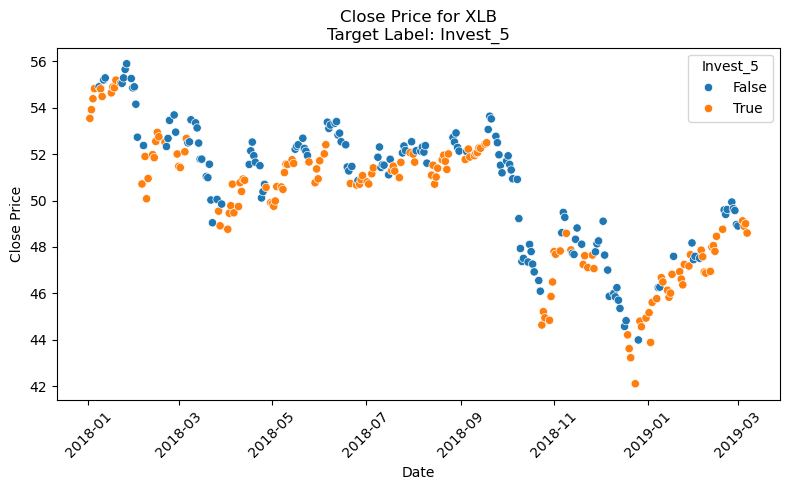

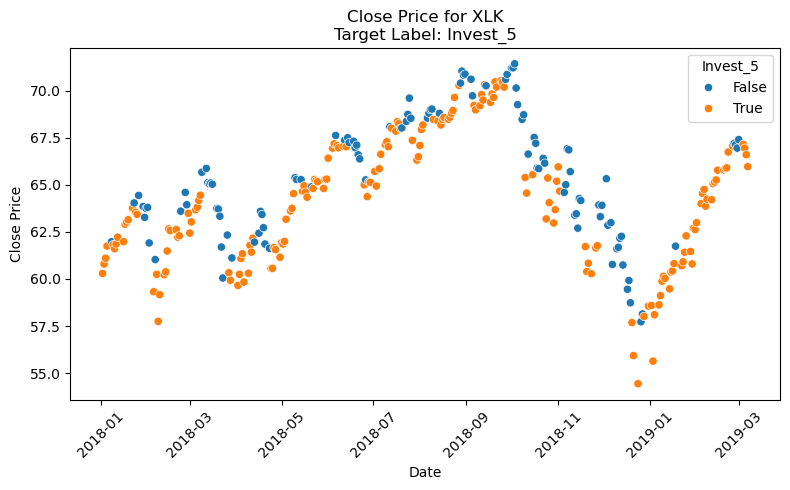

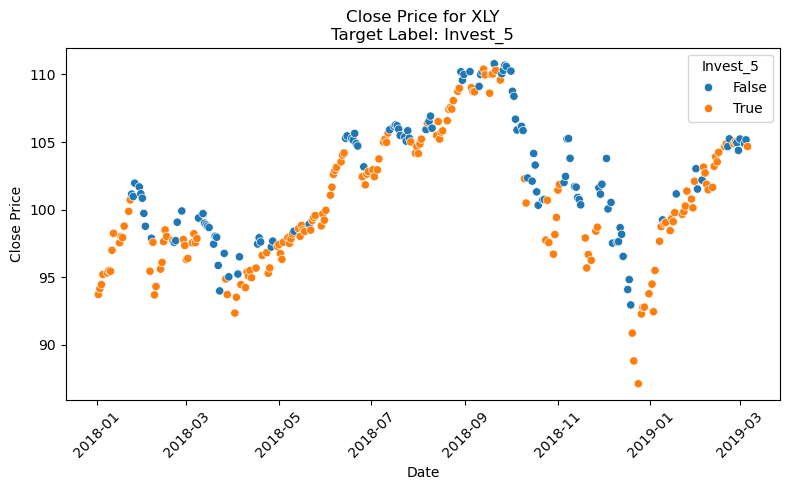

In [19]:
print('Binary Label: Invest_5')
look_period=df_19[df_19['Date']>pd.Timestamp('2018-01-01').date()]
plot_hue_column(look_period,column='Invest_5',plot_three=True)

Multiclass Label: Performance Category


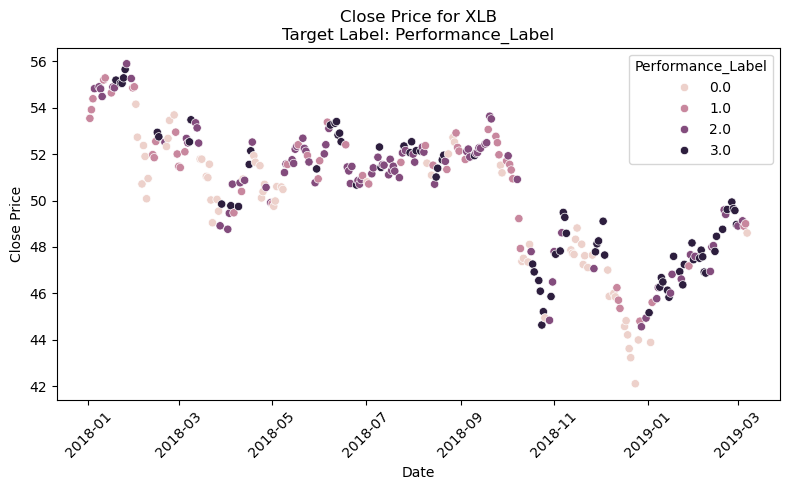

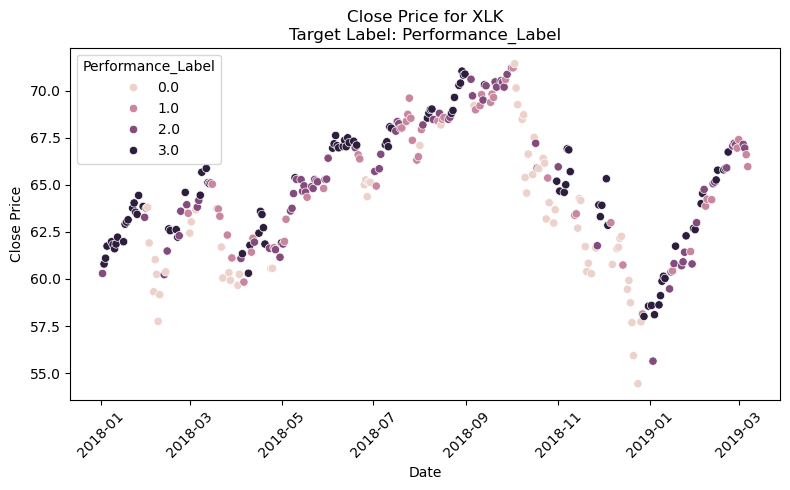

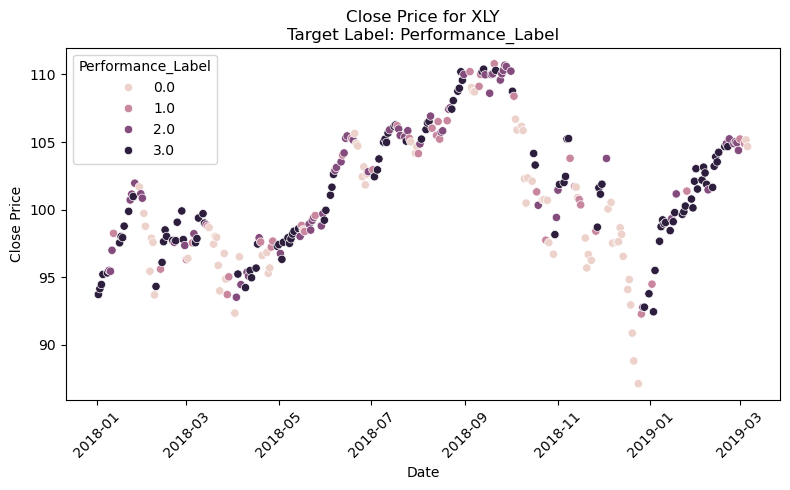

In [21]:
print('Multiclass Label: Performance Category')
plot_hue_column(look_period,column='Performance_Label',plot_three=True)

In [27]:
for col in df_19[features].columns:
    if not is_numeric_dtype(df_19[col]):
        print(col)
df_19=df_19.dropna(subset=features)

# Fit Model (xgBoost Multi Classifier)
### Training Data: 2011-2016
### Testing Data : 2016-2019


In [129]:
features=get_features(df_19,squeeze=True, tickers=False,ttm=False)
train.dropna(inplace=True)
test.dropna(inplace=True)
model,X_test,y_test,y_pred_prob=fit_multi_classifier(train,test,features,max_depth=3,n_estimators=350)

Accuracy: 0.4190501180792443

Classification Report:
              precision    recall  f1-score   support

         0.0       0.48      0.51      0.50      1472
         1.0       0.29      0.16      0.21      1705
         2.0       0.37      0.45      0.40      2345
         3.0       0.49      0.53      0.51      2100

    accuracy                           0.42      7622
   macro avg       0.41      0.41      0.40      7622
weighted avg       0.41      0.42      0.41      7622


Confusion Matrix:
[[ 757  159  376  180]
 [ 361  273  755  316]
 [ 296  353 1050  646]
 [ 155  158  673 1114]]

Top 20 Most Important Features:
                       feature  importance
0    VOO_Close_pct_change_lag1    0.016775
1    VOO_Close_pct_change_lag3    0.015853
2    VOO_Close_pct_change_lag2    0.015520
3    HYG_Close_pct_change_lag2    0.013131
4    HYG_Close_pct_change_lag1    0.010424
5    HYG_Close_pct_change_lag3    0.010059
6    Vix_Close_pct_change_lag1    0.007857
7    Vix_Close_pct_chan

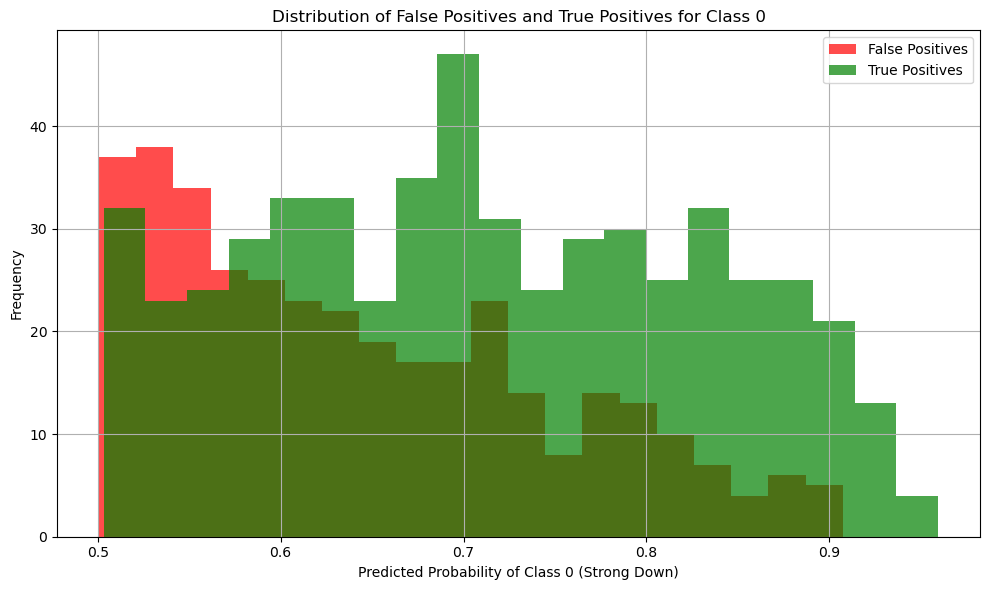

Total samples: 7622
False Positives: 362
True Positives: 538
Optimal threshold for Class 0: 0.2782

Precision at different thresholds:
Threshold 0.1: Precision = 0.2732
Threshold 0.2: Precision = 0.3694
Threshold 0.3: Precision = 0.4614
Threshold 0.4: Precision = 0.5321
Threshold 0.5: Precision = 0.5978
Threshold 0.6: Precision = 0.6741
Threshold 0.7: Precision = 0.7254
Threshold 0.8: Precision = 0.8056
Threshold 0.9: Precision = 0.8966


In [131]:
test=plot_probabilities(test,y_pred_prob)

In [133]:
test=adjust_threshold(test,threshold=0.5)

       pred_prob_class0  class_zero_above_thresh  Predicted_Action2
12498          0.079909                    False               True
12499          0.033655                    False               True
12500          0.039518                    False               True
12503          0.039733                    False               True
12504          0.049472                    False               True
12505          0.036081                    False               True
12501          0.074690                    False               True
12506          0.020861                    False               True
12507          0.010205                    False               True
12508          0.028201                    False               True

Total samples: 7622
Samples with Class 0 probability >= 0.5: 900
Samples to act on (Predicted_Action2 = True): 6722
Percentage of samples to act on: 88.19%

Shape of filtered DataFrame: (6722, 1146)

Out of the samples to act on:
Actually Class 0 (Str

In [36]:
test['Predicted_Action2'].value_counts()

Predicted_Action2
True     6874
False     770
Name: count, dtype: int64

In [135]:
print_gains_report(test,1)

*************** Results After Adjustment ***************

Average Percentage Change for Non Invest Days -0.009383112619007372%
Average Percentage Change for Invest Days 0.053097451713632046%


In [ ]:
write_predicted_action_to_csv(test,'Action_Data_1_2016-2019.csv')

# 2022-2024 Data

In [41]:
sector_stocks = {
    'XLY': ['CMG'],
    'XLP': ['PG','TGT'],
    'XLE': ['XOM'],
    'XLF': ['BRK-B'],
    'XLV': ['UNH'],
    'XLI': ['UNP'],
    'XLB': ['LIN'],
    'XLRE': ['PLD'],
    'XLK': ['AAPL'],
    'XLC': ['META'],
    'XLU': ['NEE']
}

_,df_24=pipe.prepare_dataset1(sector_stocks,start_date='2012-01-01',end_date='2024-10-05',holding_period=7,targets=[1,4,5,7],num_lags=100)
print('Number of Rows in Data set:',len(df_24))
df_24['Date'] = pd.to_datetime(df_24['Date'], utc=True).dt.tz_localize(None)
df_24.rename(columns={'Close_ETF':'Close'},inplace=True)
testing_period=df_24[df_24['Year']>2022]

module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
Found Rows with Volume=0
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
module updated
i have done this
20 20 20
38424

            UNRATE
DATE  

In [79]:
df_24.dropna(inplace=True)
df_24.rename(columns={'Ticker_ETF':'Ticker'},inplace=True)
df_24=create_performance_label3(df_24,5)
df_24.dropna(inplace=True)
df_24,train,test=get_train_test(df_24, ticker_dummies=False)

# Fit new model on 2022-2024 data.
#### Training Data includes up until 2022
#### Test set is 2022-2024.

In [109]:
features=get_features(df_24,squeeze=True, tickers=False,ttm=False)
train.dropna(inplace=True)
test.dropna(inplace=True)
model,X_test,y_test,y_pred_prob=fit_multi_classifier(train,test,features,max_depth=3,n_estimators=350)

Accuracy: 0.4160031847133758

Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.39      0.47      3109
         1.0       0.23      0.18      0.21      2319
         2.0       0.31      0.62      0.41      3036
         3.0       0.65      0.42      0.51      4096

    accuracy                           0.42     12560
   macro avg       0.45      0.40      0.40     12560
weighted avg       0.48      0.42      0.42     12560


Confusion Matrix:
[[1197  628 1074  210]
 [ 350  422 1284  263]
 [ 253  434 1886  463]
 [ 168  312 1896 1720]]

Top 20 Most Important Features:
                      feature  importance
0   VOO_Close_pct_change_lag1    0.018048
1   VOO_Close_pct_change_lag2    0.015641
2   VOO_Close_pct_change_lag3    0.015130
3   VOO_Close_pct_change_lag4    0.009642
4   HYG_Close_pct_change_lag2    0.009288
5   HYG_Close_pct_change_lag1    0.008325
6   Vix_Close_pct_change_lag2    0.007942
7   Vix_Close_pct_change_lag3  

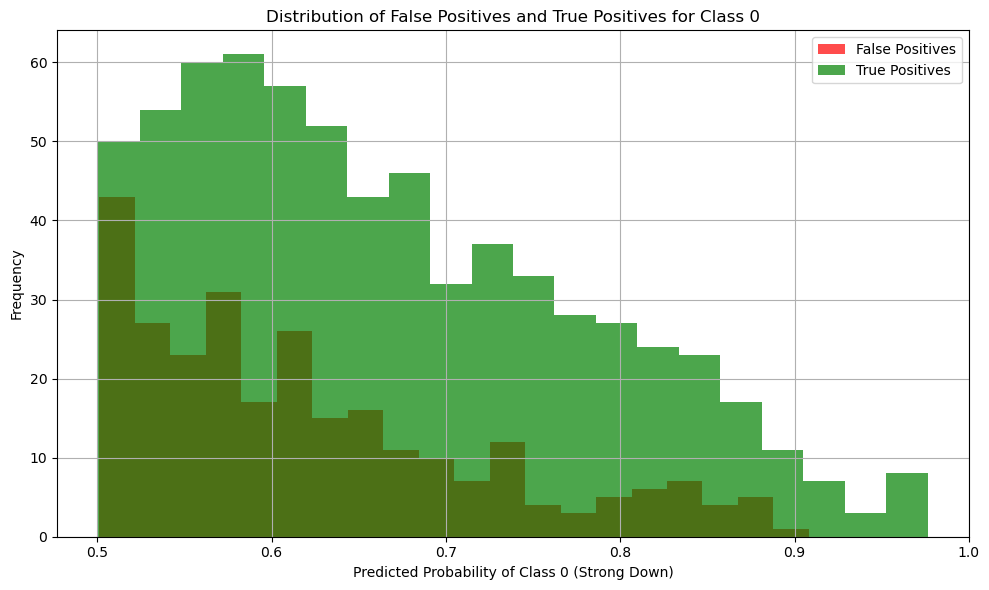

Total samples: 12560
False Positives: 273
True Positives: 673
Optimal threshold for Class 0: 0.1634

Precision at different thresholds:
Threshold 0.1: Precision = 0.3724
Threshold 0.2: Precision = 0.5138
Threshold 0.3: Precision = 0.5965
Threshold 0.4: Precision = 0.6637
Threshold 0.5: Precision = 0.7114
Threshold 0.6: Precision = 0.7704
Threshold 0.7: Precision = 0.8061
Threshold 0.8: Precision = 0.8110
Threshold 0.9: Precision = 0.9545


In [111]:
test=plot_probabilities(test,y_pred_prob)

In [113]:
test=adjust_threshold(test,threshold=0.5)

       pred_prob_class0  class_zero_above_thresh  Predicted_Action2
20073          0.595379                     True              False
20074          0.738426                     True              False
20081          0.765187                     True              False
20077          0.891859                     True              False
20078          0.816004                     True              False
20080          0.879624                     True              False
20076          0.780557                     True              False
20079          0.863447                     True              False
20086          0.612839                     True              False
20085          0.661798                     True              False

Total samples: 12560
Samples with Class 0 probability >= 0.5: 946
Samples to act on (Predicted_Action2 = True): 11614
Percentage of samples to act on: 92.47%

Shape of filtered DataFrame: (11614, 1143)

Out of the samples to act on:
Actually Class 0 (

In [87]:
test['Predicted_Action2'].value_counts()

Predicted_Action2
True     11614
False      946
Name: count, dtype: int64

In [115]:
print_gains_report(test,1)

*************** Results After Adjustment ***************

Average Percentage Change for Non Invest Days 0.045212376605338056%
Average Percentage Change for Invest Days 0.08398101080087976%


In [91]:
print_gains_report(test,5)

*************** Results After Adjustment ***************

Average Percentage Change for Non Invest Days -3.4169144101684488%
Average Percentage Change for Invest Days 0.6578783932539569%


# Attempt to improve model by using only important features from permutation feature importance.

In [58]:
import joblib
import pickle

# Save the model
joblib.dump(model, 'Non_Invest_Days_Model.joblib')

# Save the list of features
np.save('Non_Invest_Days_Features_target_5.npy',features)


In [71]:
train.dropna(inplace=True)
test.dropna(inplace=True)
keep_columns=np.load('Keep_Features_Performance_Label.npy',allow_pickle=True)
model,X_test,y_test,y_pred_prob=fit_multi_classifier(train,test,keep_columns,max_depth=3,n_estimators=350)

Accuracy: 0.4037513908758544

Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.36      0.46      3128
         1.0       0.24      0.22      0.23      2317
         2.0       0.30      0.58      0.39      3043
         3.0       0.62      0.41      0.49      4094

    accuracy                           0.40     12582
   macro avg       0.45      0.39      0.39     12582
weighted avg       0.48      0.40      0.41     12582


Confusion Matrix:
[[1126  701 1071  230]
 [ 281  518 1259  259]
 [ 224  535 1777  507]
 [ 156  373 1906 1659]]

Top 20 Most Important Features:
                      feature  importance
0   VOO_Close_pct_change_lag2    0.034518
1   VOO_Close_pct_change_lag1    0.034057
2   VOO_Close_pct_change_lag3    0.031475
3   Vix_Close_pct_change_lag1    0.023098
4   HYG_Close_pct_change_lag1    0.020620
5   HYG_Close_pct_change_lag3    0.015931
6   Vix_Close_pct_change_lag2    0.014963
7   VOO_Close_pct_change_lag4  

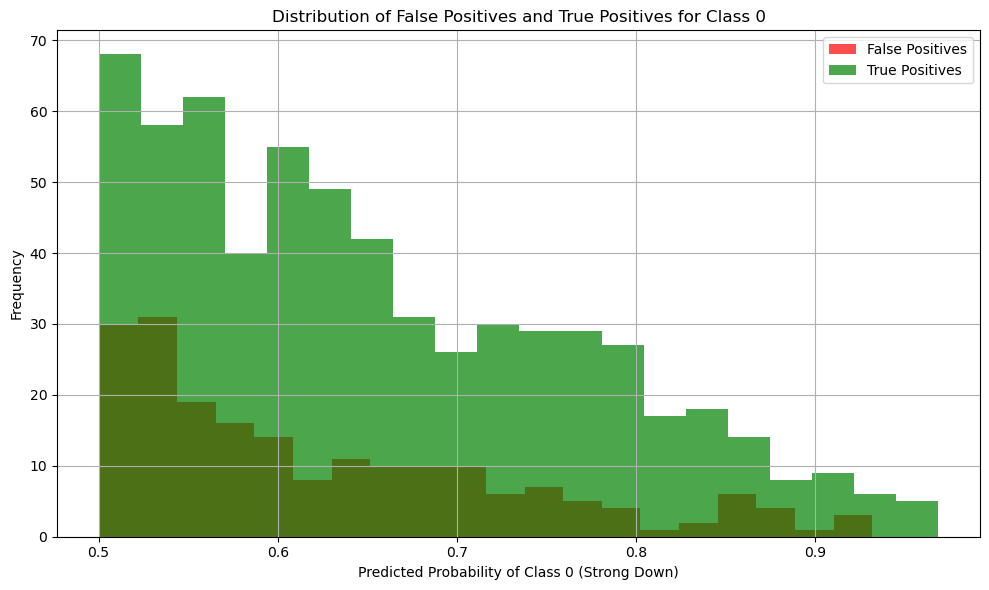

Total samples: 12582
False Positives: 198
True Positives: 623
Optimal threshold for Class 0: 0.1588

Precision at different thresholds:
Threshold 0.1: Precision = 0.3727
Threshold 0.2: Precision = 0.5180
Threshold 0.3: Precision = 0.6174
Threshold 0.4: Precision = 0.7000
Threshold 0.5: Precision = 0.7588
Threshold 0.6: Precision = 0.8013
Threshold 0.7: Precision = 0.8157
Threshold 0.8: Precision = 0.8252
Threshold 0.9: Precision = 0.8696


In [73]:
test=plot_probabilities(test,y_pred_prob)

In [95]:
test=adjust_threshold(test,threshold=0.5)

       pred_prob_class0  class_zero_above_thresh  Predicted_Action2
20073          0.595379                     True              False
20074          0.738426                     True              False
20081          0.765187                     True              False
20077          0.891859                     True              False
20078          0.816004                     True              False
20080          0.879624                     True              False
20076          0.780557                     True              False
20079          0.863447                     True              False
20086          0.612839                     True              False
20085          0.661798                     True              False

Total samples: 12560
Samples with Class 0 probability >= 0.5: 946
Samples to act on (Predicted_Action2 = True): 11614
Percentage of samples to act on: 92.47%

Shape of filtered DataFrame: (11614, 1143)

Out of the samples to act on:
Actually Class 0 (

In [77]:
test['Predicted_Action2'].value_counts()
print('Percent Gain 1 day ahead')
print_gains_report(test,1)
print()
print('Percent Gain 5 day ahead')
print_gains_report(test,5)

Percent Gain 1 day ahead
*************** Results After Adjustment ***************

Average Percentage Change for Non Invest Days -0.03554443945555353%
Average Percentage Change for Invest Days 0.08083107967451877%

Percent Gain 5 day ahead
*************** Results After Adjustment ***************

Average Percentage Change for Non Invest Days -3.9068233754258253%
Average Percentage Change for Invest Days 0.6329835249100942%


In [ ]:
write_predicted_action_to_csv(test,'Action_Data_1_2022-2024.csv')

In [119]:
test['Predicted_Action2']

20073    False
20074    False
20081    False
20077    False
20078    False
         ...  
32631     True
32632     True
32626     True
32628     True
32637     True
Name: Predicted_Action2, Length: 12560, dtype: bool

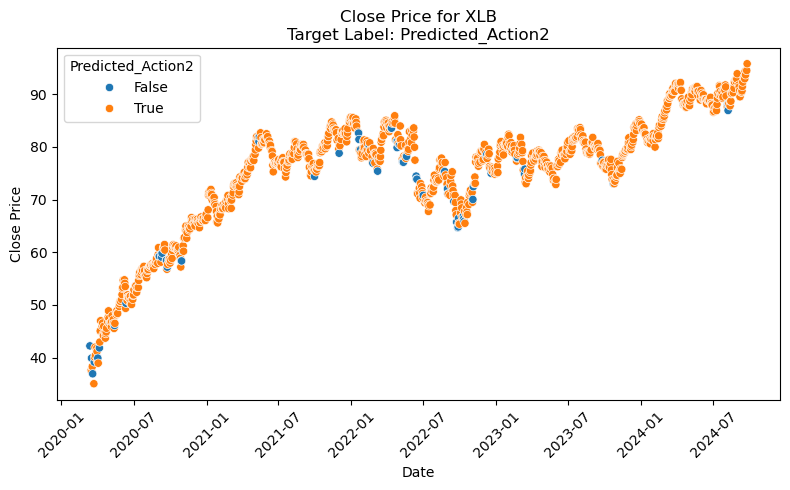

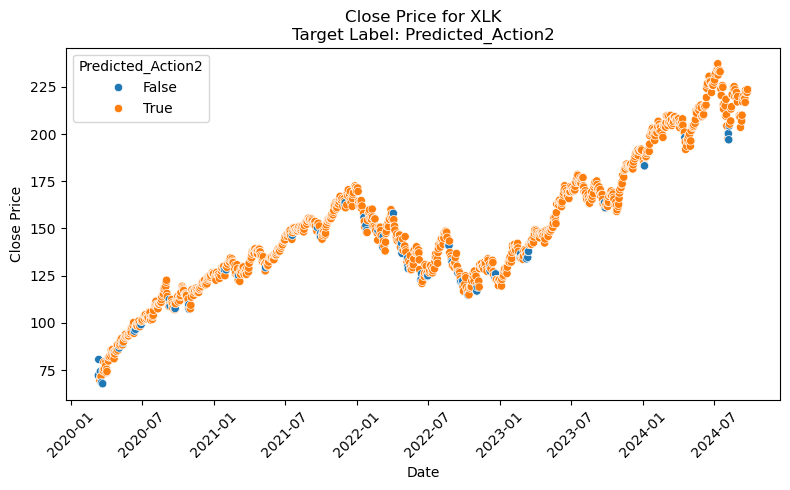

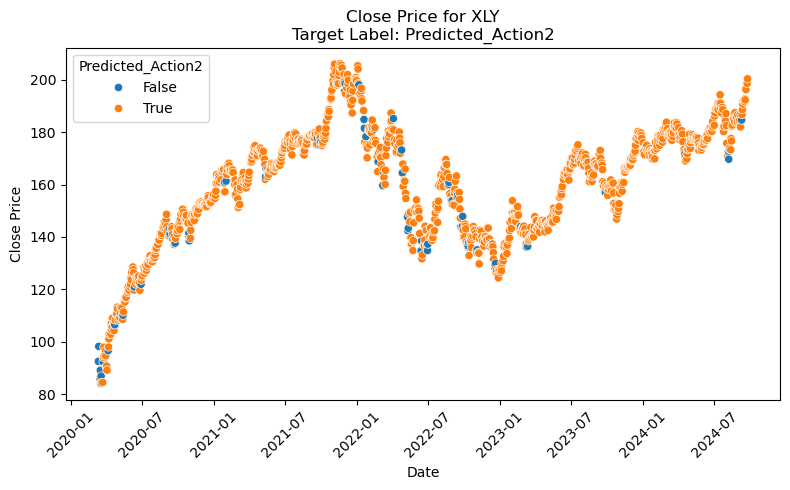

In [121]:
plot_hue_column(test,column='Predicted_Action2',plot_three=True)


In [107]:
import random
rerun=False
if rerun:
    results=mf.permutation_feature_importance(model, X_test, y_test, n_repeats=20, random_state=42)
else:
    results=pd.read_csv('Permutation_Feature_Results_ETF.csv')
    results.to_csv(f'Permutation_Importance_{random.randint(0,300)}.csv',index=False)
keep_columns=results[results['importance']>0]['feature']
results.iloc[:20]


,feature,importance,std
0,VOO_Close_pct_change_lag2,0.040757,0.002783
1,VOO_Close_pct_change_lag1,0.035622,0.002377
2,VOO_Close_pct_change_lag3,0.034267,0.002445
3,VOO_Close_pct_change_lag4,0.005393,0.001613
4,HYG_Close_pct_change_lag1,0.003898,0.001157
5,HYG_Close_pct_change_lag2,0.002651,0.001072
6,Vix_Close_pct_change_lag1,0.001860,0.001411
7,Close_pct_change_lag57,0.001649,0.000471
8,HYG_Close_pct_change_lag3,0.001633,0.000986
9,Vix_Close_pct_change_lag2,0.001319,0.001102


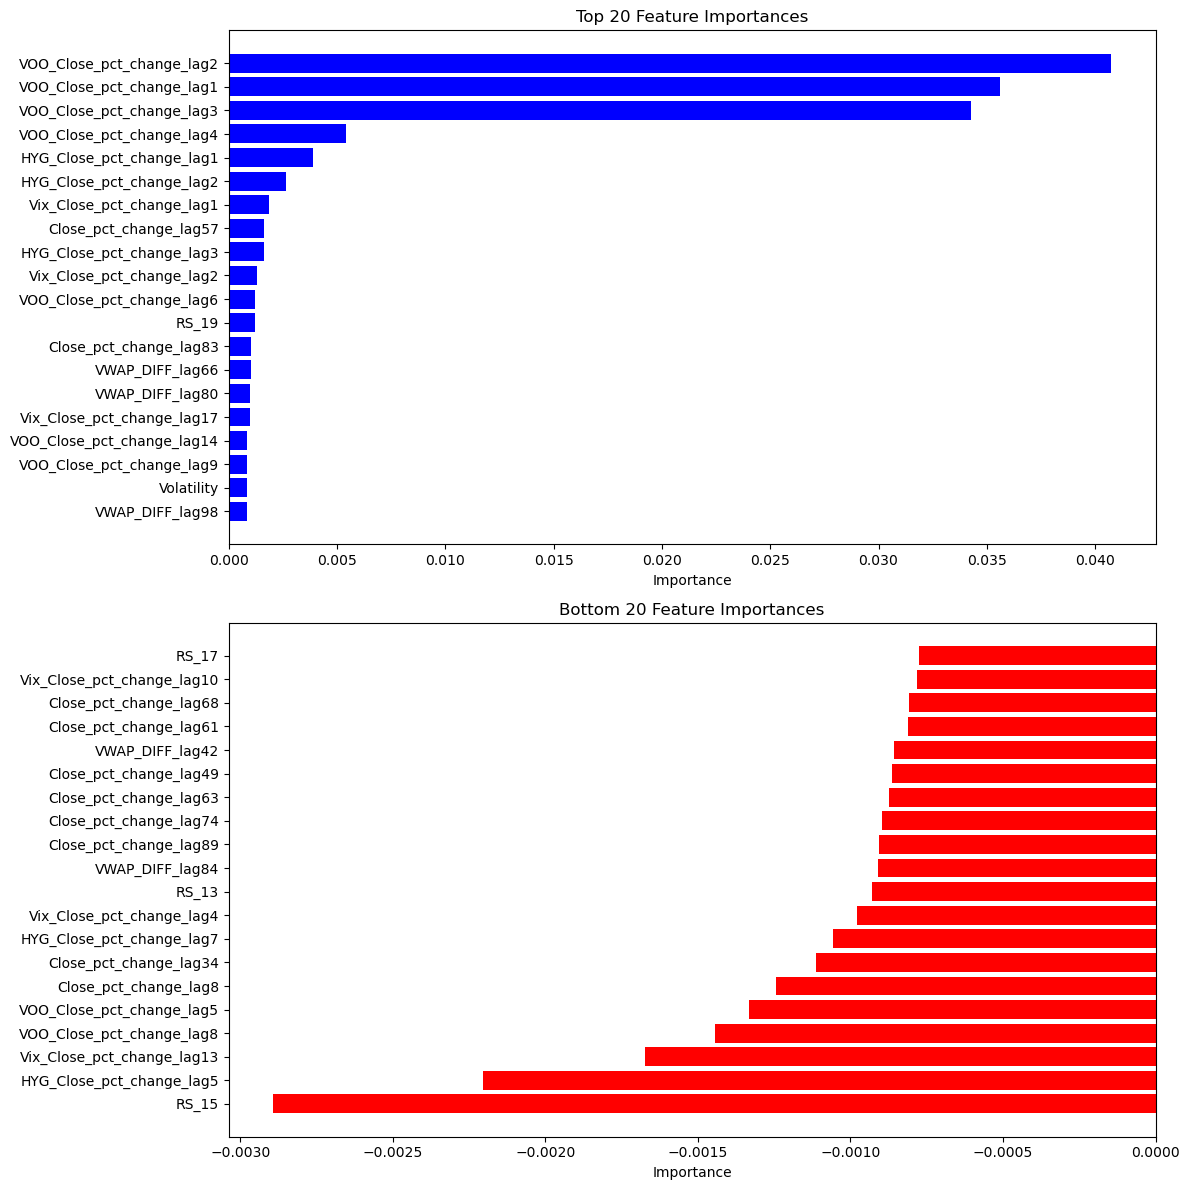

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the DataFrame by importance in descending order
results_sorted = results.sort_values('importance', ascending=False)

# Get the top 20 and bottom 20 features
top_20 = results_sorted.head(20)
bottom_20 = results_sorted.tail(20)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot top 20 features
ax1.barh(top_20['feature'], top_20['importance'], color='blue')
ax1.set_title('Top 20 Feature Importances')
ax1.set_xlabel('Importance')
ax1.invert_yaxis()  # To display the highest importance at the top

# Plot bottom 20 features
ax2.barh(bottom_20['feature'], bottom_20['importance'], color='red')
ax2.set_title('Bottom 20 Feature Importances')
ax2.set_xlabel('Importance')
ax2.invert_yaxis()  # To display the lowest importance at the bottom

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [68]:
np.save('Keep_Features_Performance_Label.npy',keep_columns.values)

In [105]:
results.to_csv('Permutation_Feature_Results_ETF.csv',index=False)